In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import GPy
#import multiprocessing as mp
#from concurrent.futures import ProcessPoolExecutor

from numpy import genfromtxt
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import preprocessing

from matplotlib import style
style.use('seaborn-white')

In [2]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [3]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
mu_c = 0.0005
mu_p = 0.000002
gravity = 9.8 
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = -0.2+0.5*np.sin(6*ts[i]) #-0.2+
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

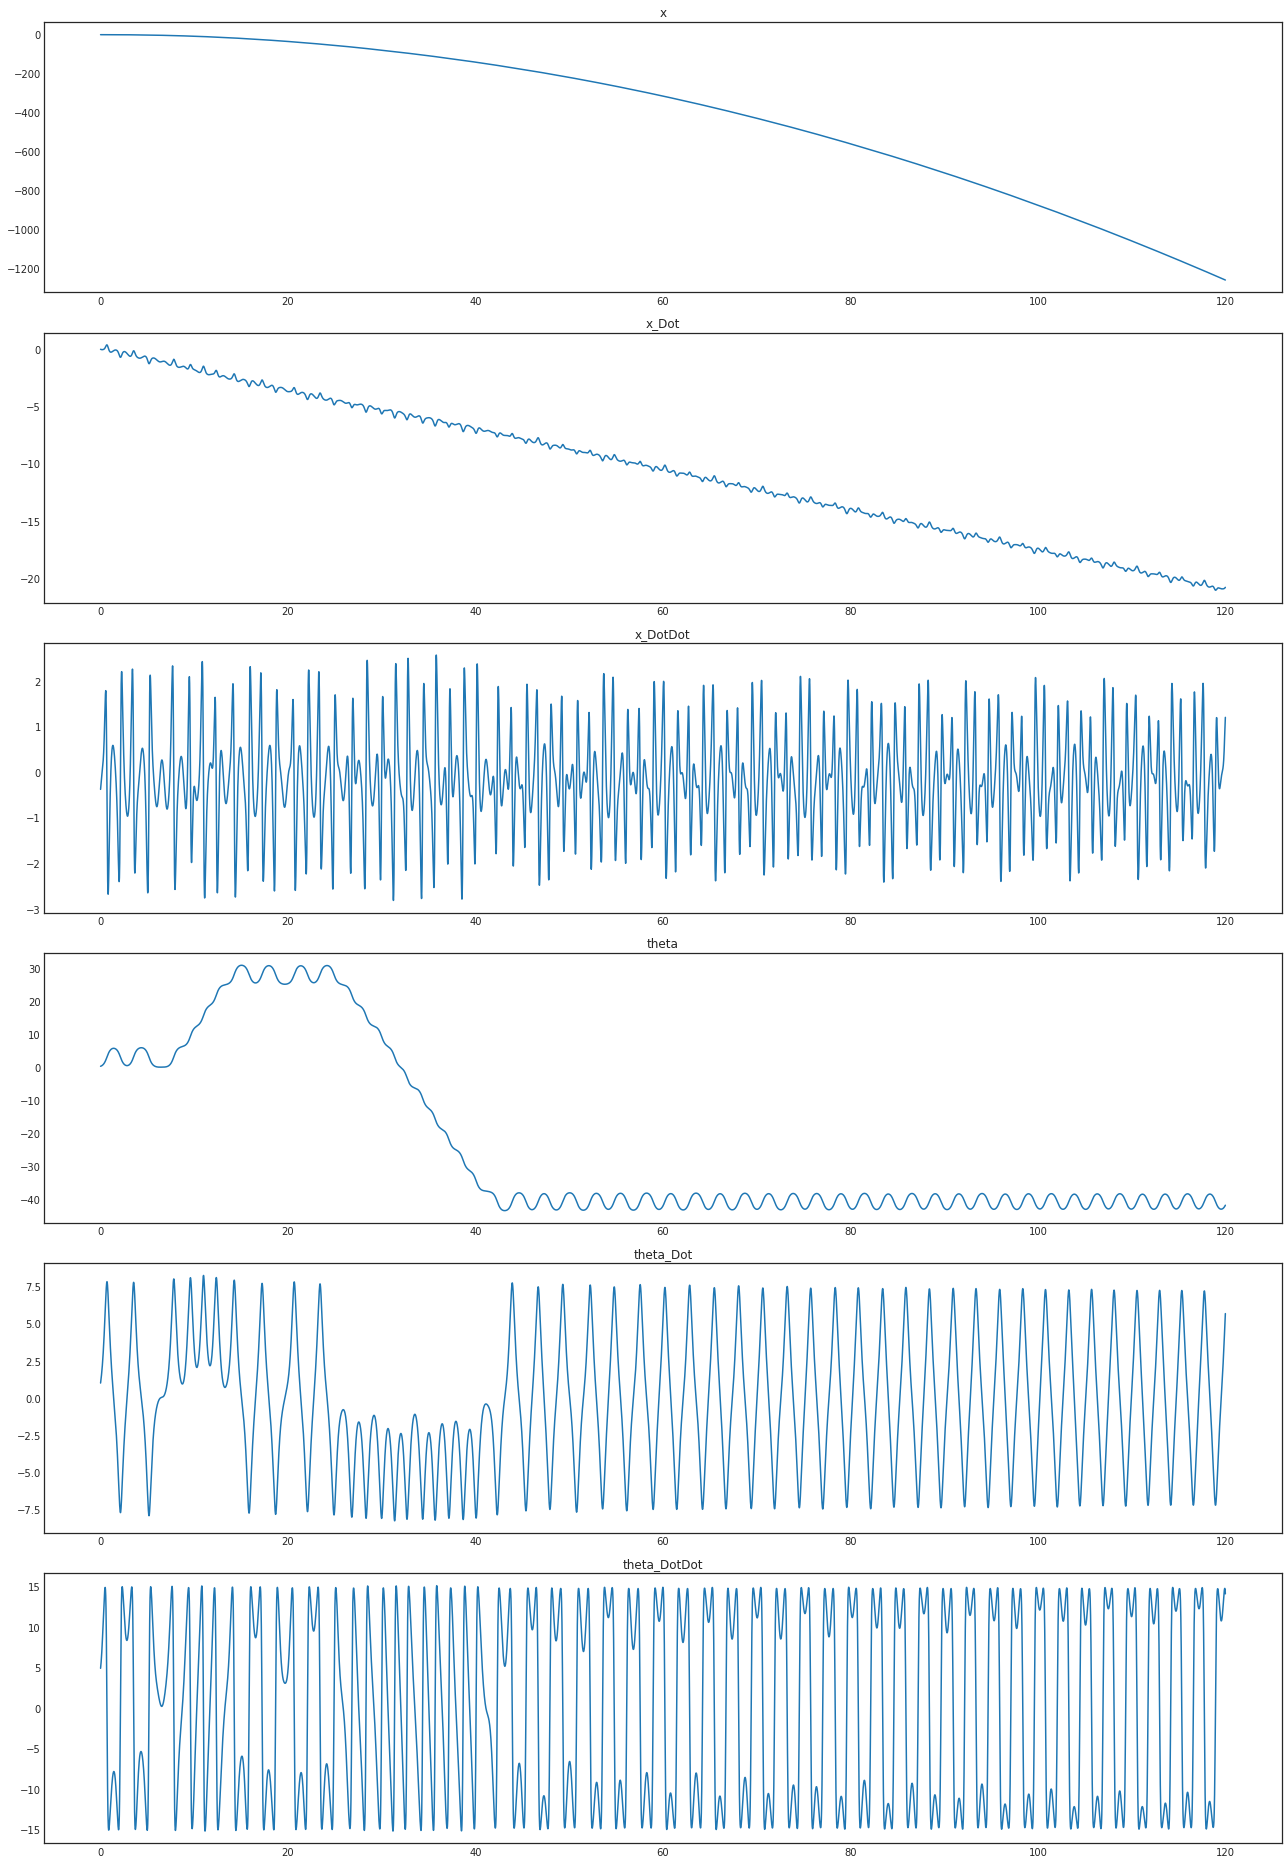

In [4]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

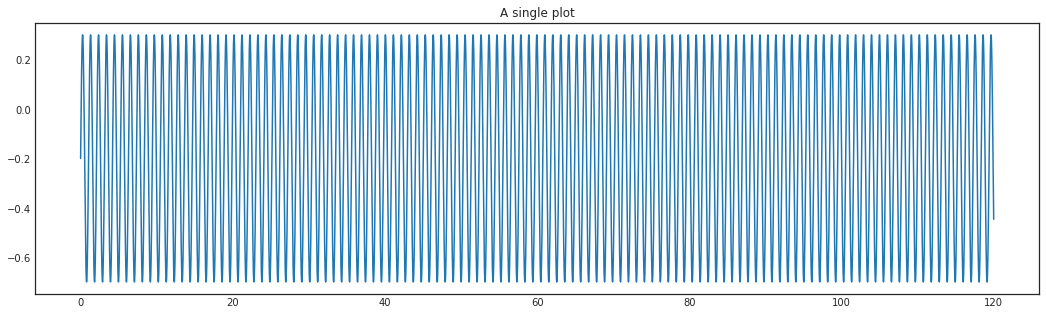

In [5]:
# Force Input Plot 
forceIn = -0.2+0.5*np.sin(6*timeSteps) #-0.2+
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

In [6]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev).reshape(-1,1)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev).reshape(-1,1)  # RMSE(V)

Y_train = np.stack((Y_train_theta, Y_train_x), axis=1) # For MultiOutput GP

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

X_pred_th = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev, np.zeros(theta_dd_sim.shape[0])), axis=1) # Prior
X_pred_x = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev, np.ones(theta_dd_sim.shape[0])), axis=1) # Prior

In [ ]:
noise = 0.017

gauss = GPy.likelihoods.Gaussian()
gauss_der = GPy.likelihoods.Gaussian()

#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)

#myKernel = k1*k2
Kernel = GPy.kern.RBF(input_dim=4, ARD=True) 
gpr = GPy.models.MultioutputGP(X_list=[X_train, X_train], Y_list=[Y_train_theta, Y_train_x], 
                               kernel_list=[Kernel, Kernel], likelihood_list=[gauss, gauss_der])

# Fix the noise variance to known value 
#gpr.Gaussian_noise.variance = noise**2
#gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize()

# Display optimized parameter values
display(gpr)

gp.,value,constraints,priors
MultioutputDerivativeKern.rbf.variance,15.267626473390067,+ve,
MultioutputDerivativeKern.rbf.lengthscale,"(4,)",+ve,
multioutput_likelihood.Gaussian_noise.variance,6.929395724838085e-148,+ve,
multioutput_likelihood.Gaussian_noise_1.variance,0.754111169448468,+ve,


In [ ]:
np.save('../../learnedModels/deterministicCase/MultiOutGPwithGPy/MultiOutGPwithGPyRBF(Rank1).npy', gpr.param_array)

In [9]:
gauss = GPy.likelihoods.Gaussian()
gauss_der = GPy.likelihoods.Gaussian()
Kernel = GPy.kern.RBF(input_dim=4, ARD=True) 
gpr = GPy.models.MultioutputGP(X_list=[X_train, X_train], Y_list=[Y_train_theta, Y_train_x], 
                               kernel_list=[Kernel, Kernel], likelihood_list=[gauss, gauss_der], initialize=False)
gpr.update_model(False) # do not call the underlying expensive algebra on load
gpr.initialize_parameter() # Initialize the parameters (connect the parameters up)
gpr[:] = np.load('../../learnedModels/deterministicCase/MultiOutGPwithGPy/MultiOutGPwithGPyRBF(Rank1).npy') # Load the parameters
gpr.initialize_parameter()
gpr.update_model(True) # Call the algebra only once
print(gpr)


Name : gp
Objective : -53053.73195761764
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                               |                   value  |  constraints  |  priors
  MultioutputDerivativeKern.rbf.variance            |      15.267626473390067  |      +ve      |        
  MultioutputDerivativeKern.rbf.lengthscale         |                    (4,)  |      +ve      |        
  multioutput_likelihood.Gaussian_noise.variance    |  6.929395724838085e-148  |      +ve      |        
  multioutput_likelihood.Gaussian_noise_1.variance  |       0.754111169448468  |      +ve      |        


In [10]:
mu_th, var_th = gpr.predict(X_pred_th, Y_metadata={"output_index": X_pred_th[:,-1:].astype(np.int)})
mu_x, var_x = gpr.predict(X_pred_x, Y_metadata={"output_index": X_pred_x[:,-1:].astype(np.int)})

In [11]:
Y_theta = np.hstack((Y_train_theta.reshape(-1), Y_test_theta))
Y_x = np.hstack((Y_train_x.reshape(-1), Y_test_x))
allData = np.stack((mu_th.reshape(-1), var_th.reshape(-1), mu_x.reshape(-1), var_x.reshape(-1), Y_theta, Y_x), axis=1)
np.savetxt('../../../Results/deterministicCase/MultiOutGPwithGPy/MultiOutGPwithGPyRBF(Rank1).csv', allData, delimiter=',')

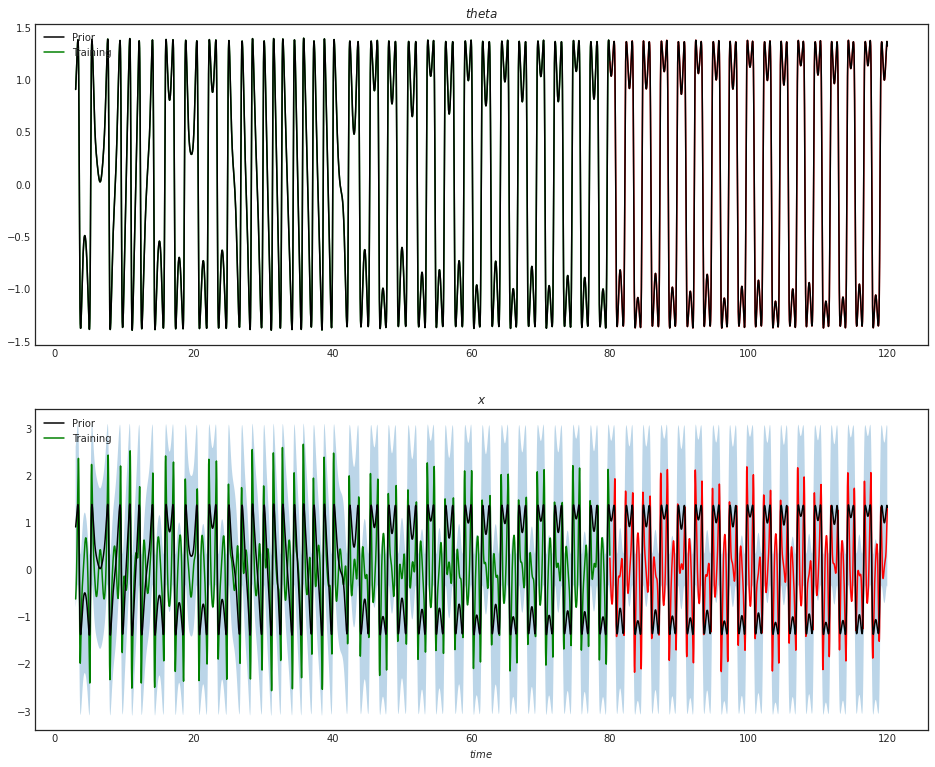

In [12]:
uncertainty_th = 1.96 * np.sqrt(var_th)
uncertainty_x = 1.96 * np.sqrt(var_x)

#my_data = genfromtxt('../../../Results/deterministicCase/TwoOutGPwithGPy/TwoOutGPy(ARD)(Rank2).csv', delimiter=',')
#mu_th = my_data[:,0]
#var_th = my_data[:,1]
#mu_x = my_data[:,2]
#var_x = my_data[:,3]
#Y_theta = my_data[:,4]
#Y_x = my_data[:,5]

start_Traj = 300
end_Traj = 11999
train_test_split = 8000

fig, ax = plt.subplots(2) 

fig.set_figheight(13)
fig.set_figwidth(16)

ax[0].fill_between(timeSteps[start_Traj:end_Traj], mu_th.reshape(-1)[start_Traj:end_Traj] + uncertainty_th.reshape(-1)[start_Traj:end_Traj], mu_th.reshape(-1)[start_Traj:end_Traj] - uncertainty_th.reshape(-1)[start_Traj:end_Traj], alpha=0.3)
p1, = ax[0].plot(timeSteps[start_Traj:train_test_split], Y_train_theta[start_Traj:], 'g')
ax[0].plot(timeSteps[train_test_split:end_Traj], Y_test_theta[:end_Traj-train_test_split], 'r')
g1, = ax[0].plot(timeSteps[start_Traj:end_Traj], mu_th[start_Traj:end_Traj], 'k')
ax[0].set_title('$theta$')
ax[0].legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")

ax[1].fill_between(timeSteps[start_Traj:end_Traj], mu_x.reshape(-1)[start_Traj:end_Traj] + uncertainty_x.reshape(-1)[start_Traj:end_Traj], mu_x.reshape(-1)[start_Traj:end_Traj] - uncertainty_x.reshape(-1)[start_Traj:end_Traj], alpha=0.3)
p1, = ax[1].plot(timeSteps[start_Traj:train_test_split], Y_train_x[start_Traj:], 'g')
ax[1].plot(timeSteps[train_test_split:end_Traj], Y_test_x[:end_Traj-train_test_split], 'r')
g1, = ax[1].plot(timeSteps[start_Traj:end_Traj], mu_x[start_Traj:end_Traj], 'k')
ax[1].set_title('$x$')
ax[1].legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")

#plt.savefig('../../../Results/deterministicCase/MultiOutGPwithGPy/MultiOutGPwithGPyRBF(Rank1).png')
plt.show()